In [ ]:
import librosa
import numpy as np
from scipy.stats import entropy, chisquare
import matplotlib.pyplot as plt

def load_timit_sample(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr


Pipeline for frame

In [ ]:
def frame_based_analysis_pipeline(y, sr):
    # Short-Time Fourier Transform (STFT)
    stft_result = librosa.stft(y, n_fft=int(0.025 * sr), hop_length=int(0.01 * sr))

    stft_result -= np.mean(stft_result, axis=0)

    magnitude_spectrum = np.abs(stft_result)

    # Removing the first element (DC component)
    magnitude_spectrum = magnitude_spectrum[1:, :]

    # Normalization
    min_value = np.min(magnitude_spectrum[magnitude_spectrum > 0])
    magnitude_spectrum /= min_value
    # print(np.count_nonzero(magnitude_spectrum))
    return magnitude_spectrum



Benfords Law Evaluation

In [ ]:
def extract_leading_digit(x):
    return int(str(x)[0])

def calculate_leading_digit_distribution(magnitude_spectrum):
    leading_digits = np.vectorize(extract_leading_digit)(magnitude_spectrum)
    leading_digit_counts = np.bincount(leading_digits.flatten(), minlength=10)[1:]
    epsilon = 1e-10
    leading_digit_probs = leading_digit_counts / (np.sum(leading_digit_counts) + epsilon)

    return leading_digit_probs

def ideal_benford_distribution():
    return np.array([np.log10(1 + 1/d) for d in range(1, 10)])

def evaluate_benford_law(magnitude_spectrum):
    empirical_distribution = calculate_leading_digit_distribution(magnitude_spectrum)
    benford_distribution = ideal_benford_distribution()

    slope, intercept = np.polyfit(benford_distribution, empirical_distribution, 1)
    eval = []
    eval.append([slope,intercept])
    print(eval)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 10), empirical_distribution, 'o-', label='Empirical Distribution')
    plt.plot(range(1, 10), benford_distribution, 's-', label='Benford Distribution')
    plt.xlabel('Leading Digit')
    plt.ylabel('Probability')
    plt.title('Empirical vs Benford Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

    chi2_stat, p_value = chisquare(empirical_distribution, f_exp=benford_distribution)

    print(f"Chi-square statistic: {chi2_stat}")
    print(f"P-value: {p_value}")
    # Evaluate the p-value
    if p_value < 0.05:
        print("The deviation is statistically significant. Hence it does not follow benfords Law")
    else:
        print("The deviation is not statistically significant. It follows benfords law")

    return slope, intercept


In [ ]:
# Step 4: BenfordSimilarity (BenS) Features

def calculate_kl_divergence(empirical_distribution, benford_distribution):
    return entropy(empirical_distribution, benford_distribution)

def benford_similarity_features(y, sr):
    magnitude_spectrum = frame_based_analysis_pipeline(y, sr)

    num_frames = magnitude_spectrum.shape[1]
    benford_distribution = ideal_benford_distribution()

    kl_divergences = []

    for i in range(num_frames):
        frame = magnitude_spectrum[:, i]
        empirical_distribution = calculate_leading_digit_distribution(frame)

        if np.any(empirical_distribution == 0):
            # Skip frames with zero probability for any leading digit
            continue

        kl_div = calculate_kl_divergence(empirical_distribution, benford_distribution)
        kl_divergences.append(kl_div)

    kl_divergences = np.array(kl_divergences)


    # Extracting statistics
    mean_kl = np.mean(kl_divergences)
    std_kl = np.std(kl_divergences)
    percentiles_kl = np.percentile(kl_divergences, [10, 20, 30, 40, 50, 60, 70 ,80 ,90])

    return mean_kl, std_kl, percentiles_kl

[[0.987065473536301, 0.001437169607077308]]


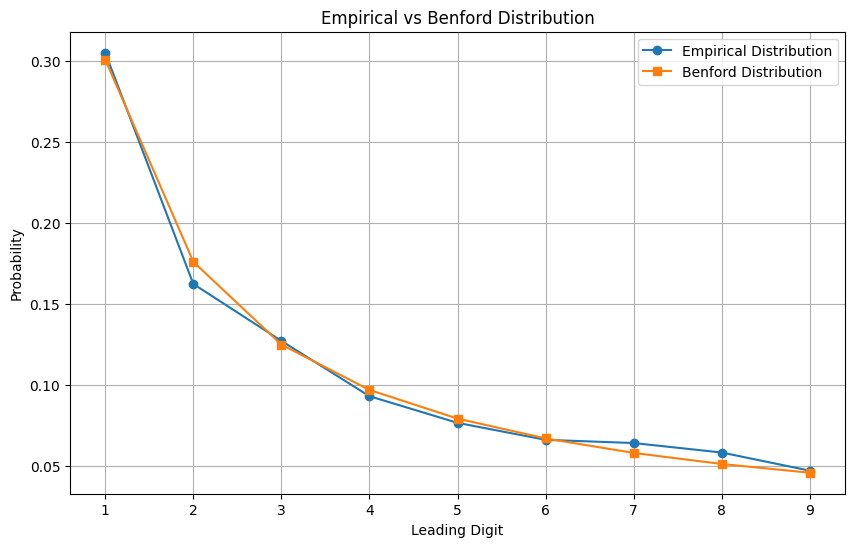

Chi-square statistic: 0.0030747153321481267
P-value: 0.9999999999997675
The deviation is not statistically significant. It follows benfords law
Mean KL Divergence: 0.060549325214478256
Standard Deviation of KL Divergence: 0.04658674452211295
Percentiles (10, 20, 30, 40, 50, 60, 70 ,80 ,90): [0.02049291 0.02966863 0.03586726 0.04188866 0.04688532 0.05492351
 0.06341194 0.07788266 0.11161659]


In [ ]:
file_path = 'f1.wav'
y, sr = load_timit_sample(file_path)
mean_kl, std_kl, percentiles_kl = benford_similarity_features(y, sr)

# Evaluate Benford Law and plot the distribution
magnitude_spectrum = frame_based_analysis_pipeline(y, sr)
slope, intercept = evaluate_benford_law(magnitude_spectrum)

print(f"Mean KL Divergence: {mean_kl}")
print(f"Standard Deviation of KL Divergence: {std_kl}")
print(f"Percentiles (10, 20, 30, 40, 50, 60, 70 ,80 ,90): {percentiles_kl}")
